In [1]:
import os
import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import pandas as pd

from typing import List
import numpy as np

# 1. Data
# 2. Model
# 3. Prediction
# 4. Filter data 
# 5. Training loop
# 6. Metrics
# 7. Save the model

In [2]:
genre_mapping = {
    0: "Blues",
    1: "Classical",
    2: "Country",
    3: "Disco",
    4: "Hiphop",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "Reggae",
    9: "Rock",
}

In [3]:
genre_mapping_inverse = {
    "Blues": 0,
    "Classical": 1,
    "Country": 2,
    "Disco": 3,
    "Hiphop": 4,
    "Jazz": 5,
    "Metal": 6,
    "Pop": 7,
    "Reggae": 8,
    "Rock": 9,
}

In [4]:
column_names = [
    "chroma_stft_mean",
    "chroma_stft_var",
    "rms_mean",
    "rms_var",
    "spectral_centroid_mean",
    "spectral_centroid_var",
    "spectral_bandwidth_mean",
    "spectral_bandwidth_var",
    "rolloff_mean",
    "rolloff_var",
    "zero_crossing_rate_mean",
    "zero_crossing_rate_var",
    "harmony_mean",
    "harmony_var",
    "tempo",
    "mfcc1_mean",
    "mfcc1_var",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    "mfcc4_var",
    "mfcc5_mean",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc7_var",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_mean",
    "mfcc10_var",
    "mfcc11_mean",
    "mfcc11_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc13_var",
    "mfcc14_mean",
    "mfcc14_var",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc17_var",
    "mfcc18_mean",
    "mfcc18_var",
    "mfcc19_mean",
    "mfcc19_var",
    "mfcc20_mean",
    "mfcc20_var",
]

In [5]:
class MusicClassifier(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features, out_features=256, dtype=torch.float32
            ),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=128, out_features=output_features, dtype=torch.float32
            ),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [6]:
def training_loop(MusicClassifier: MusicClassifier):
    # TODO: Externalise this
    # Init le model
    torch.manual_seed(42)
    model = MusicClassifier(input_features=55, output_features=10)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

    def accuracy_fn(y_true, y_pred):
        correct = (
            torch.eq(input=y_true, other=y_pred).sum().item()
        )  # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
        return acc

    # Prepare data
    df = pd.read_csv("./csv/actual_dataset.csv")
    # df = pd.read_csv("/app/resources/original_dataset.csv")
    X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32)
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 125
    for epoch in range(epochs + 1):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        # loss_history.append(loss.cpu().detach().numpy())
        # acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Test
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            test_loss = loss_fn(y_test_logits, y_test)
            test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

            # 2.1 Save metrics
            # test_loss_history.append(test_loss.cpu().detach().numpy())
            # test_acc_history.append(test_acc)

        # Print out what's happening
        if epoch % 25 == 0:
            print(
                f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
            )

    # if epoch == 125:
    cm = confusion_matrix(y_test, y_test_pred.numpy())
    ConfusionMatrixDisplay(cm).plot()
    # Save the model
    torch.save(obj=model.state_dict(), f="./actual_model_fast.pth")

In [7]:
def predict(
    model: MusicClassifier, df: pd.DataFrame, genre_mapping: dict[int, str], real_class: str
):
    # TODO: Rewrite
    model.eval()

    class_predictions = []
    raw_results = []
    total_rows, _ = df.shape
    for i in range(total_rows):
        # print(df.iloc[i].to_numpy().reshape(55,1))
        y_logits = model(torch.from_numpy(df.iloc[i].to_numpy().reshape(55,1).transpose()).type(torch.float32))

        y_softmax = torch.softmax(y_logits, dim=1)
        y_pred = y_softmax.argmax(dim=1)

        # print(genre_mapping[y_pred.detach().numpy()[0]])
        # print(list(torch.round(y_softmax * 1000) / 1000))

        raw_results.append(y_softmax.detach().numpy())
        class_predictions.append(genre_mapping[y_pred.detach().numpy()[0]])

    unique_values = set(class_predictions)
    actual_best = 0
    for elt in unique_values:
        if class_predictions.count(elt) > actual_best:
            actual_best = class_predictions.count(elt)
            prediction = elt
        # print(elt, class_predictions.count(elt))
    # print("Real class =>", real_class)
    # print("Results =>", genre_mapping_inverse[prediction])
    return prediction, raw_results

In [8]:
def filter_data(kept_df: pd.DataFrame, seuil: float, raw_results: list, dataframe: pd.DataFrame, real_class: int):
    for i in range(len(raw_results)):
            if raw_results[i][0][int(real_class)] > seuil:
                kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)
                kept_df['label'] = real_class
    return kept_df

In [9]:
def training_loop(MusicClassifier: MusicClassifier, df: pd.DataFrame, ):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Init le model
    torch.manual_seed(42)
    model = MusicClassifier(input_features=55, output_features=10).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

    def accuracy_fn(y_true, y_pred):
        correct = (
            torch.eq(input=y_true, other=y_pred).sum().item()
        )  # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
        return acc

    # Prepare data
    # df = pd.read_csv("./csv/actual_dataset.csv")
    # df = pd.read_csv("/app/resources/original_dataset.csv")
    X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32).to(device)
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long).to(device)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 125
    for epoch in range(epochs + 1):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        # loss_history.append(loss.cpu().detach().numpy())
        # acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Test
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            test_loss = loss_fn(y_test_logits, y_test)
            test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

            # 2.1 Save metrics
            # test_loss_history.append(test_loss.cpu().detach().numpy())
            # test_acc_history.append(test_acc)

        # Print out what's happening
        if epoch == 125:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

    # if epoch == 125:
    cm = confusion_matrix(y_test.cpu(), y_test_pred.cpu().numpy())
    ConfusionMatrixDisplay(cm).plot()

    print(classification_report(y_true=y_test.cpu(), y_pred=y_test_pred.cpu()))
    # Save the model
    # torch.save(obj=model.state_dict(), f="./actual_model_fast.pth")

/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07100, Acc: 97.84% | Test Loss: 0.38796, Test Acc: 90.06%
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       210
           1       0.90      0.95      0.92       201
           2       0.91      0.87      0.89       189
           3       0.91      0.87      0.89       202
           4       0.90      0.92      0.91       215
           5       0.86      0.92      0.89       202
           6       0.96      0.92      0.94       206
           7       0.94      0.91      0.92       183
           8       0.87      0.94      0.91       198
           9       0.86      0.79      0.82       196

    accuracy                           0.90      2002
   macro avg       0.90      0.90      0.90      2002
weighted avg       0.90      0.90      0.90      2002



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07026, Acc: 97.73% | Test Loss: 0.35007, Test Acc: 91.32%
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       207
           1       0.92      0.95      0.93       203
           2       0.84      0.88      0.86       188
           3       0.95      0.90      0.93       206
           4       0.93      0.91      0.92       215
           5       0.89      0.90      0.90       184
           6       0.96      0.97      0.97       213
           7       0.94      0.93      0.93       201
           8       0.93      0.92      0.92       203
           9       0.86      0.82      0.84       184

    accuracy                           0.91      2004
   macro avg       0.91      0.91      0.91      2004
weighted avg       0.91      0.91      0.91      2004



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.08036, Acc: 97.32% | Test Loss: 0.33482, Test Acc: 90.97%
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       209
           1       0.90      0.95      0.93       202
           2       0.91      0.85      0.88       180
           3       0.90      0.89      0.90       201
           4       0.94      0.91      0.92       207
           5       0.90      0.92      0.91       201
           6       0.95      0.94      0.95       198
           7       0.90      0.93      0.92       190
           8       0.93      0.95      0.94       206
           9       0.85      0.81      0.83       211

    accuracy                           0.91      2005
   macro avg       0.91      0.91      0.91      2005
weighted avg       0.91      0.91      0.91      2005



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07167, Acc: 97.64% | Test Loss: 0.34720, Test Acc: 90.70%
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       209
           1       0.89      0.95      0.92       200
           2       0.89      0.86      0.88       193
           3       0.88      0.89      0.88       194
           4       0.92      0.91      0.91       229
           5       0.88      0.90      0.89       204
           6       0.97      0.95      0.96       205
           7       0.92      0.91      0.92       199
           8       0.93      0.93      0.93       184
           9       0.86      0.86      0.86       193

    accuracy                           0.91      2010
   macro avg       0.91      0.91      0.91      2010
weighted avg       0.91      0.91      0.91      2010



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07375, Acc: 97.67% | Test Loss: 0.36915, Test Acc: 90.90%
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       215
           1       0.92      0.97      0.94       215
           2       0.86      0.88      0.87       193
           3       0.94      0.87      0.90       206
           4       0.90      0.92      0.91       207
           5       0.89      0.90      0.89       210
           6       0.97      0.95      0.96       190
           7       0.94      0.94      0.94       200
           8       0.90      0.94      0.92       202
           9       0.87      0.79      0.83       184

    accuracy                           0.91      2022
   macro avg       0.91      0.91      0.91      2022
weighted avg       0.91      0.91      0.91      2022



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06940, Acc: 97.77% | Test Loss: 0.34261, Test Acc: 91.23%
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       220
           1       0.92      0.98      0.95       241
           2       0.85      0.92      0.88       185
           3       0.92      0.90      0.91       212
           4       0.91      0.91      0.91       205
           5       0.92      0.92      0.92       199
           6       0.97      0.90      0.93       191
           7       0.93      0.92      0.92       210
           8       0.93      0.90      0.92       197
           9       0.84      0.87      0.85       182

    accuracy                           0.91      2042
   macro avg       0.91      0.91      0.91      2042
weighted avg       0.91      0.91      0.91      2042



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06877, Acc: 97.79% | Test Loss: 0.36028, Test Acc: 90.62%
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       218
           1       0.94      0.97      0.95       229
           2       0.85      0.89      0.87       202
           3       0.87      0.90      0.88       208
           4       0.92      0.94      0.93       201
           5       0.89      0.90      0.89       197
           6       0.97      0.96      0.97       189
           7       0.94      0.89      0.91       197
           8       0.90      0.91      0.91       207
           9       0.86      0.80      0.83       198

    accuracy                           0.91      2046
   macro avg       0.91      0.91      0.91      2046
weighted avg       0.91      0.91      0.91      2046



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06812, Acc: 97.73% | Test Loss: 0.37218, Test Acc: 90.22%
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       213
           1       0.93      0.98      0.96       250
           2       0.85      0.88      0.86       194
           3       0.87      0.90      0.88       205
           4       0.93      0.88      0.91       223
           5       0.92      0.89      0.91       199
           6       0.96      0.96      0.96       195
           7       0.91      0.91      0.91       197
           8       0.90      0.88      0.89       203
           9       0.85      0.78      0.81       177

    accuracy                           0.90      2056
   macro avg       0.90      0.90      0.90      2056
weighted avg       0.90      0.90      0.90      2056



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07183, Acc: 97.59% | Test Loss: 0.36886, Test Acc: 91.44%
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       215
           1       0.92      0.99      0.96       249
           2       0.86      0.90      0.88       201
           3       0.88      0.89      0.88       203
           4       0.93      0.91      0.92       201
           5       0.92      0.89      0.91       204
           6       0.96      0.96      0.96       186
           7       0.93      0.92      0.93       187
           8       0.91      0.92      0.92       210
           9       0.88      0.81      0.84       200

    accuracy                           0.91      2056
   macro avg       0.91      0.91      0.91      2056
weighted avg       0.91      0.91      0.91      2056



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07356, Acc: 97.58% | Test Loss: 0.30031, Test Acc: 91.20%
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       215
           1       0.93      0.98      0.95       245
           2       0.86      0.88      0.87       195
           3       0.89      0.89      0.89       200
           4       0.90      0.95      0.92       197
           5       0.91      0.87      0.89       211
           6       0.97      0.98      0.97       203
           7       0.91      0.91      0.91       200
           8       0.94      0.92      0.93       204
           9       0.88      0.79      0.83       187

    accuracy                           0.91      2057
   macro avg       0.91      0.91      0.91      2057
weighted avg       0.91      0.91      0.91      2057



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07786, Acc: 97.52% | Test Loss: 0.37970, Test Acc: 90.48%
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       216
           1       0.92      0.97      0.95       254
           2       0.94      0.84      0.89       200
           3       0.86      0.89      0.87       209
           4       0.93      0.91      0.92       214
           5       0.90      0.91      0.91       199
           6       0.95      0.95      0.95       185
           7       0.91      0.89      0.90       185
           8       0.88      0.91      0.89       207
           9       0.84      0.81      0.83       189

    accuracy                           0.90      2058
   macro avg       0.90      0.90      0.90      2058
weighted avg       0.91      0.90      0.90      2058



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06793, Acc: 97.79% | Test Loss: 0.40900, Test Acc: 90.82%
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       217
           1       0.90      0.98      0.94       249
           2       0.87      0.88      0.88       206
           3       0.90      0.89      0.90       217
           4       0.92      0.87      0.89       209
           5       0.92      0.89      0.91       199
           6       0.94      0.97      0.96       192
           7       0.94      0.93      0.93       189
           8       0.91      0.94      0.93       209
           9       0.84      0.79      0.82       171

    accuracy                           0.91      2058
   macro avg       0.91      0.91      0.91      2058
weighted avg       0.91      0.91      0.91      2058



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07776, Acc: 97.32% | Test Loss: 0.41730, Test Acc: 90.00%
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       212
           1       0.90      0.98      0.94       243
           2       0.83      0.86      0.84       197
           3       0.88      0.85      0.86       214
           4       0.94      0.90      0.92       205
           5       0.93      0.90      0.92       216
           6       0.97      0.96      0.96       203
           7       0.91      0.94      0.93       194
           8       0.87      0.92      0.89       198
           9       0.84      0.72      0.78       189

    accuracy                           0.90      2071
   macro avg       0.90      0.90      0.90      2071
weighted avg       0.90      0.90      0.90      2071



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07195, Acc: 97.67% | Test Loss: 0.32705, Test Acc: 92.05%
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       216
           1       0.93      0.97      0.95       249
           2       0.85      0.93      0.89       203
           3       0.95      0.89      0.92       206
           4       0.94      0.95      0.94       195
           5       0.91      0.90      0.91       209
           6       0.94      0.96      0.95       202
           7       0.94      0.94      0.94       203
           8       0.91      0.92      0.92       208
           9       0.89      0.79      0.84       185

    accuracy                           0.92      2076
   macro avg       0.92      0.92      0.92      2076
weighted avg       0.92      0.92      0.92      2076



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07376, Acc: 97.69% | Test Loss: 0.35649, Test Acc: 91.54%
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       217
           1       0.94      0.97      0.95       242
           2       0.85      0.87      0.86       190
           3       0.96      0.87      0.91       201
           4       0.94      0.93      0.93       207
           5       0.92      0.91      0.91       237
           6       0.92      0.94      0.93       196
           7       0.92      0.94      0.93       187
           8       0.92      0.93      0.93       216
           9       0.87      0.82      0.85       187

    accuracy                           0.92      2080
   macro avg       0.91      0.91      0.91      2080
weighted avg       0.92      0.92      0.92      2080



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07066, Acc: 97.87% | Test Loss: 0.41416, Test Acc: 90.39%
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       212
           1       0.92      0.96      0.94       239
           2       0.81      0.88      0.84       189
           3       0.86      0.86      0.86       204
           4       0.92      0.88      0.90       222
           5       0.91      0.90      0.90       231
           6       0.96      0.97      0.97       190
           7       0.89      0.95      0.92       198
           8       0.93      0.94      0.93       199
           9       0.89      0.77      0.82       197

    accuracy                           0.90      2081
   macro avg       0.90      0.90      0.90      2081
weighted avg       0.90      0.90      0.90      2081



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07514, Acc: 97.42% | Test Loss: 0.37938, Test Acc: 90.73%
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       213
           1       0.94      0.95      0.95       238
           2       0.84      0.87      0.85       190
           3       0.83      0.85      0.84       204
           4       0.94      0.89      0.91       223
           5       0.90      0.93      0.92       234
           6       0.96      0.94      0.95       190
           7       0.92      0.95      0.94       191
           8       0.93      0.94      0.93       207
           9       0.85      0.81      0.83       192

    accuracy                           0.91      2082
   macro avg       0.91      0.91      0.91      2082
weighted avg       0.91      0.91      0.91      2082



/tmp/ipykernel_59447/2200193255.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07514, Acc: 97.42% | Test Loss: 0.37938, Test Acc: 90.73%
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       213
           1       0.94      0.95      0.95       238
           2       0.84      0.87      0.85       190
           3       0.83      0.85      0.84       204
           4       0.94      0.89      0.91       223
           5       0.90      0.93      0.92       234
           6       0.96      0.94      0.95       190
           7       0.92      0.95      0.94       191
           8       0.93      0.94      0.93       207
           9       0.85      0.81      0.83       192

    accuracy                           0.91      2082
   macro avg       0.91      0.91      0.91      2082
weighted avg       0.91      0.91      0.91      2082



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06999, Acc: 97.91% | Test Loss: 0.38270, Test Acc: 90.38%
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       211
           1       0.93      0.97      0.95       240
           2       0.81      0.89      0.85       197
           3       0.88      0.85      0.86       215
           4       0.89      0.92      0.91       194
           5       0.93      0.93      0.93       229
           6       0.96      0.96      0.96       198
           7       0.91      0.93      0.92       195
           8       0.93      0.89      0.91       207
           9       0.89      0.78      0.83       203

    accuracy                           0.90      2089
   macro avg       0.90      0.90      0.90      2089
weighted avg       0.90      0.90      0.90      2089



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07476, Acc: 97.70% | Test Loss: 0.38044, Test Acc: 90.52%
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       210
           1       0.94      0.96      0.95       242
           2       0.84      0.87      0.85       193
           3       0.91      0.83      0.87       222
           4       0.94      0.91      0.92       212
           5       0.88      0.91      0.90       225
           6       0.93      0.95      0.94       190
           7       0.88      0.96      0.92       182
           8       0.94      0.94      0.94       211
           9       0.87      0.81      0.84       213

    accuracy                           0.91      2100
   macro avg       0.90      0.91      0.90      2100
weighted avg       0.91      0.91      0.90      2100



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07722, Acc: 97.49% | Test Loss: 0.33033, Test Acc: 90.93%
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       210
           1       0.94      0.96      0.95       247
           2       0.79      0.88      0.84       182
           3       0.91      0.87      0.89       221
           4       0.95      0.94      0.94       216
           5       0.91      0.91      0.91       222
           6       0.97      0.96      0.97       199
           7       0.92      0.94      0.93       193
           8       0.91      0.92      0.92       208
           9       0.87      0.78      0.82       208

    accuracy                           0.91      2106
   macro avg       0.91      0.91      0.91      2106
weighted avg       0.91      0.91      0.91      2106



/home/payetquentin/Documents/workspace/briefs/S11_music3/.venv/lib/python3.11/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07823, Acc: 97.53% | Test Loss: 0.36699, Test Acc: 91.50%
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       212
           1       0.92      0.97      0.94       239
           2       0.84      0.89      0.86       180
           3       0.92      0.87      0.89       219
           4       0.94      0.94      0.94       216
           5       0.94      0.91      0.93       223
           6       0.96      0.97      0.96       195
           7       0.92      0.95      0.93       195
           8       0.97      0.90      0.93       219
           9       0.86      0.83      0.84       209

    accuracy                           0.92      2107
   macro avg       0.91      0.91      0.91      2107
weighted avg       0.92      0.92      0.91      2107



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07598, Acc: 97.57% | Test Loss: 0.34647, Test Acc: 91.88%
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       212
           1       0.93      0.97      0.95       236
           2       0.90      0.89      0.89       180
           3       0.92      0.88      0.90       219
           4       0.94      0.94      0.94       216
           5       0.94      0.92      0.93       223
           6       0.94      0.96      0.95       195
           7       0.92      0.95      0.93       195
           8       0.96      0.91      0.93       219
           9       0.85      0.82      0.83       212

    accuracy                           0.92      2107
   macro avg       0.92      0.92      0.92      2107
weighted avg       0.92      0.92      0.92      2107



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07592, Acc: 97.78% | Test Loss: 0.39812, Test Acc: 90.60%
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       211
           1       0.92      0.98      0.95       244
           2       0.86      0.89      0.88       194
           3       0.92      0.86      0.89       235
           4       0.89      0.90      0.89       192
           5       0.90      0.91      0.91       224
           6       0.97      0.94      0.96       203
           7       0.92      0.92      0.92       202
           8       0.89      0.90      0.90       195
           9       0.87      0.84      0.86       216

    accuracy                           0.91      2116
   macro avg       0.91      0.91      0.91      2116
weighted avg       0.91      0.91      0.91      2116



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07932, Acc: 97.36% | Test Loss: 0.36284, Test Acc: 90.66%
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       209
           1       0.92      0.96      0.94       236
           2       0.82      0.87      0.84       191
           3       0.90      0.85      0.87       220
           4       0.93      0.91      0.92       207
           5       0.92      0.89      0.91       236
           6       0.95      0.96      0.96       195
           7       0.90      0.93      0.91       201
           8       0.94      0.90      0.92       226
           9       0.87      0.86      0.87       199

    accuracy                           0.91      2120
   macro avg       0.91      0.91      0.91      2120
weighted avg       0.91      0.91      0.91      2120



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07360, Acc: 97.62% | Test Loss: 0.35656, Test Acc: 91.31%
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       209
           1       0.91      0.97      0.94       238
           2       0.86      0.90      0.88       209
           3       0.92      0.91      0.91       219
           4       0.90      0.91      0.91       199
           5       0.92      0.90      0.91       229
           6       0.97      0.94      0.96       204
           7       0.93      0.93      0.93       187
           8       0.94      0.93      0.94       220
           9       0.89      0.80      0.84       216

    accuracy                           0.91      2130
   macro avg       0.91      0.91      0.91      2130
weighted avg       0.91      0.91      0.91      2130



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07329, Acc: 97.56% | Test Loss: 0.35406, Test Acc: 91.51%
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       206
           1       0.93      0.97      0.95       237
           2       0.87      0.90      0.89       210
           3       0.93      0.89      0.91       231
           4       0.89      0.93      0.91       201
           5       0.91      0.89      0.90       235
           6       0.95      0.95      0.95       194
           7       0.91      0.94      0.92       203
           8       0.94      0.91      0.92       195
           9       0.92      0.86      0.89       219

    accuracy                           0.92      2131
   macro avg       0.92      0.92      0.92      2131
weighted avg       0.92      0.92      0.91      2131



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07646, Acc: 97.36% | Test Loss: 0.40813, Test Acc: 90.49%
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       208
           1       0.91      0.96      0.93       237
           2       0.86      0.86      0.86       200
           3       0.90      0.91      0.91       230
           4       0.90      0.90      0.90       206
           5       0.92      0.92      0.92       226
           6       0.96      0.97      0.96       190
           7       0.94      0.90      0.92       197
           8       0.91      0.92      0.92       231
           9       0.87      0.79      0.83       219

    accuracy                           0.90      2144
   macro avg       0.91      0.90      0.90      2144
weighted avg       0.90      0.90      0.90      2144



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07252, Acc: 97.88% | Test Loss: 0.35115, Test Acc: 90.72%
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       210
           1       0.93      0.95      0.94       237
           2       0.82      0.88      0.85       204
           3       0.87      0.87      0.87       218
           4       0.92      0.91      0.92       208
           5       0.91      0.92      0.92       243
           6       0.97      0.96      0.96       211
           7       0.94      0.92      0.93       177
           8       0.91      0.93      0.92       218
           9       0.89      0.83      0.86       219

    accuracy                           0.91      2145
   macro avg       0.91      0.91      0.91      2145
weighted avg       0.91      0.91      0.91      2145



/tmp/ipykernel_59447/2200193255.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07252, Acc: 97.88% | Test Loss: 0.35115, Test Acc: 90.72%
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       210
           1       0.93      0.95      0.94       237
           2       0.82      0.88      0.85       204
           3       0.87      0.87      0.87       218
           4       0.92      0.91      0.92       208
           5       0.91      0.92      0.92       243
           6       0.97      0.96      0.96       211
           7       0.94      0.92      0.93       177
           8       0.91      0.93      0.92       218
           9       0.89      0.83      0.86       219

    accuracy                           0.91      2145
   macro avg       0.91      0.91      0.91      2145
weighted avg       0.91      0.91      0.91      2145



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07957, Acc: 97.33% | Test Loss: 0.38361, Test Acc: 90.86%
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       212
           1       0.91      0.97      0.94       231
           2       0.83      0.85      0.84       192
           3       0.90      0.88      0.89       233
           4       0.93      0.92      0.93       212
           5       0.92      0.91      0.92       236
           6       0.95      0.97      0.96       215
           7       0.93      0.95      0.94       182
           8       0.94      0.90      0.92       220
           9       0.86      0.82      0.84       212

    accuracy                           0.91      2145
   macro avg       0.91      0.91      0.91      2145
weighted avg       0.91      0.91      0.91      2145



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07215, Acc: 97.70% | Test Loss: 0.38850, Test Acc: 90.31%
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       208
           1       0.91      0.98      0.94       241
           2       0.86      0.81      0.83       198
           3       0.90      0.88      0.89       226
           4       0.90      0.94      0.92       203
           5       0.92      0.89      0.91       228
           6       0.96      0.98      0.97       196
           7       0.91      0.90      0.91       207
           8       0.93      0.89      0.91       226
           9       0.87      0.84      0.86       213

    accuracy                           0.90      2146
   macro avg       0.90      0.90      0.90      2146
weighted avg       0.90      0.90      0.90      2146



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.08287, Acc: 97.07% | Test Loss: 0.36196, Test Acc: 90.42%
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       205
           1       0.94      0.95      0.94       234
           2       0.82      0.88      0.85       201
           3       0.90      0.88      0.89       226
           4       0.93      0.90      0.92       219
           5       0.89      0.92      0.90       217
           6       0.95      0.95      0.95       211
           7       0.89      0.95      0.92       171
           8       0.93      0.92      0.92       240
           9       0.88      0.79      0.83       227

    accuracy                           0.90      2151
   macro avg       0.90      0.91      0.90      2151
weighted avg       0.90      0.90      0.90      2151



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07732, Acc: 97.50% | Test Loss: 0.34285, Test Acc: 91.91%
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       205
           1       0.95      0.97      0.96       247
           2       0.91      0.82      0.86       196
           3       0.93      0.91      0.92       238
           4       0.95      0.94      0.94       202
           5       0.89      0.94      0.91       216
           6       0.94      0.97      0.96       200
           7       0.91      0.94      0.92       194
           8       0.93      0.94      0.93       231
           9       0.89      0.83      0.86       222

    accuracy                           0.92      2151
   macro avg       0.92      0.92      0.92      2151
weighted avg       0.92      0.92      0.92      2151



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06956, Acc: 97.57% | Test Loss: 0.40172, Test Acc: 90.83%
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       207
           1       0.92      0.96      0.94       228
           2       0.84      0.84      0.84       195
           3       0.93      0.89      0.91       224
           4       0.90      0.91      0.90       217
           5       0.90      0.92      0.91       217
           6       0.95      0.95      0.95       200
           7       0.92      0.91      0.92       197
           8       0.93      0.95      0.94       237
           9       0.90      0.86      0.88       237

    accuracy                           0.91      2159
   macro avg       0.91      0.91      0.91      2159
weighted avg       0.91      0.91      0.91      2159



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07196, Acc: 97.63% | Test Loss: 0.34186, Test Acc: 91.32%
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       206
           1       0.93      0.97      0.95       232
           2       0.84      0.89      0.86       193
           3       0.88      0.90      0.89       221
           4       0.93      0.95      0.94       210
           5       0.92      0.91      0.91       239
           6       0.96      0.96      0.96       227
           7       0.95      0.92      0.94       181
           8       0.91      0.93      0.92       250
           9       0.89      0.76      0.82       208

    accuracy                           0.91      2167
   macro avg       0.91      0.91      0.91      2167
weighted avg       0.91      0.91      0.91      2167



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07554, Acc: 97.67% | Test Loss: 0.36665, Test Acc: 90.42%
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       206
           1       0.92      0.96      0.94       235
           2       0.85      0.87      0.86       194
           3       0.89      0.90      0.89       220
           4       0.92      0.93      0.92       216
           5       0.88      0.89      0.88       215
           6       0.95      0.95      0.95       222
           7       0.91      0.92      0.92       206
           8       0.92      0.89      0.91       241
           9       0.90      0.82      0.86       217

    accuracy                           0.90      2172
   macro avg       0.90      0.90      0.90      2172
weighted avg       0.90      0.90      0.90      2172



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07778, Acc: 97.42% | Test Loss: 0.45278, Test Acc: 90.23%
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       209
           1       0.89      0.97      0.93       232
           2       0.82      0.87      0.85       204
           3       0.88      0.90      0.89       239
           4       0.91      0.86      0.89       212
           5       0.90      0.90      0.90       235
           6       0.96      0.96      0.96       222
           7       0.94      0.91      0.92       194
           8       0.94      0.92      0.93       233
           9       0.87      0.80      0.83       200

    accuracy                           0.90      2180
   macro avg       0.90      0.90      0.90      2180
weighted avg       0.90      0.90      0.90      2180



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07782, Acc: 97.32% | Test Loss: 0.41067, Test Acc: 90.33%
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       208
           1       0.90      0.98      0.94       245
           2       0.82      0.87      0.85       195
           3       0.88      0.89      0.89       237
           4       0.96      0.92      0.94       248
           5       0.91      0.86      0.89       216
           6       0.96      0.95      0.96       220
           7       0.91      0.91      0.91       199
           8       0.91      0.91      0.91       223
           9       0.85      0.83      0.84       212

    accuracy                           0.90      2203
   macro avg       0.90      0.90      0.90      2203
weighted avg       0.90      0.90      0.90      2203



/tmp/ipykernel_59447/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07047, Acc: 97.52% | Test Loss: 0.43574, Test Acc: 89.84%
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       212
           1       0.92      0.98      0.95       237
           2       0.83      0.84      0.84       199
           3       0.92      0.87      0.90       236
           4       0.91      0.91      0.91       271
           5       0.90      0.92      0.91       208
           6       0.96      0.94      0.95       226
           7       0.91      0.91      0.91       191
           8       0.88      0.89      0.88       224
           9       0.85      0.82      0.84       211

    accuracy                           0.90      2215
   macro avg       0.90      0.90      0.90      2215
weighted avg       0.90      0.90      0.90      2215



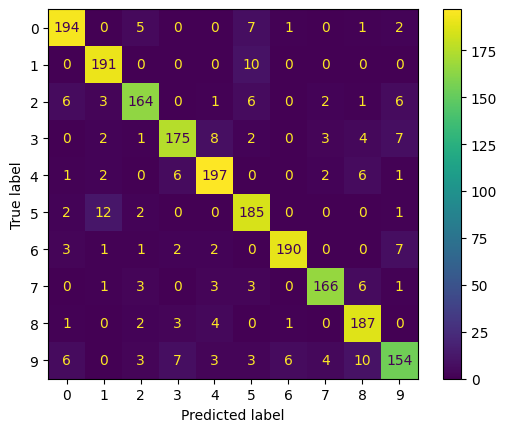

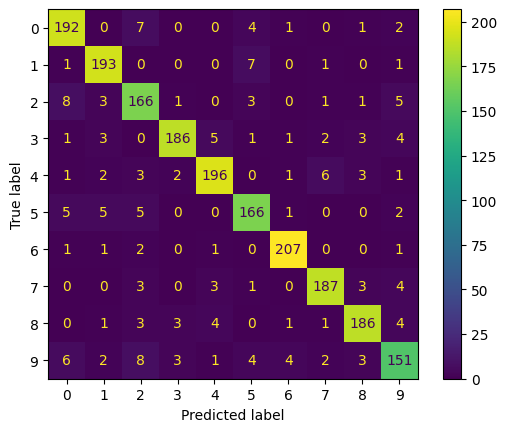

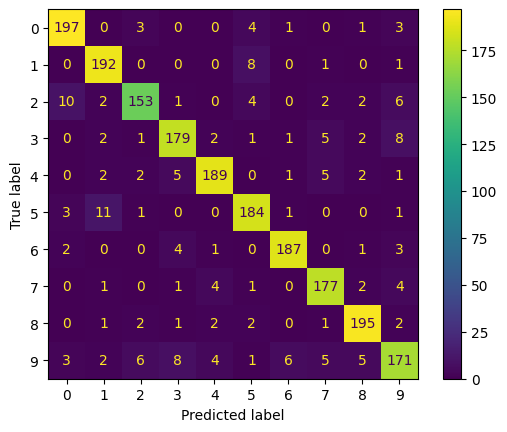

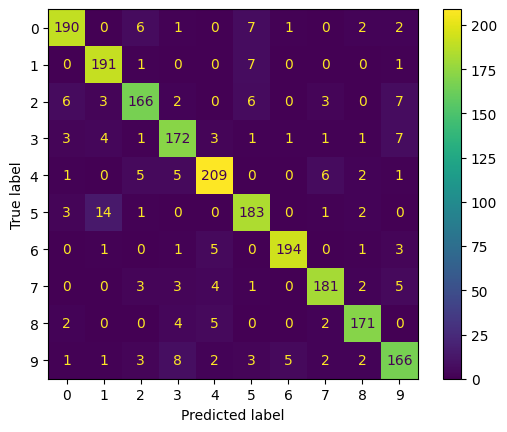

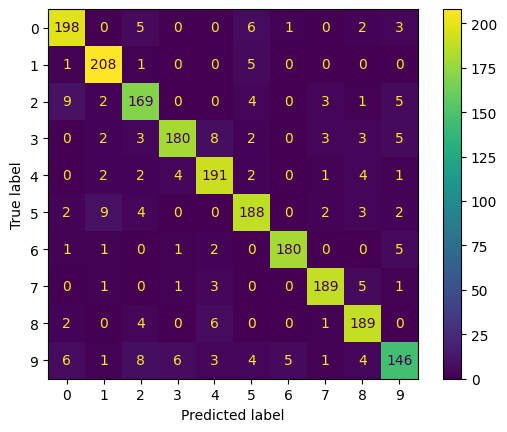

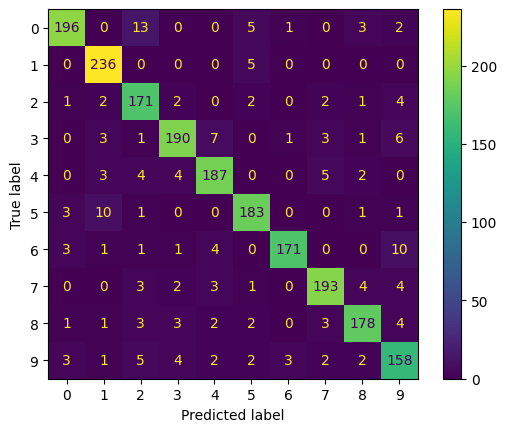

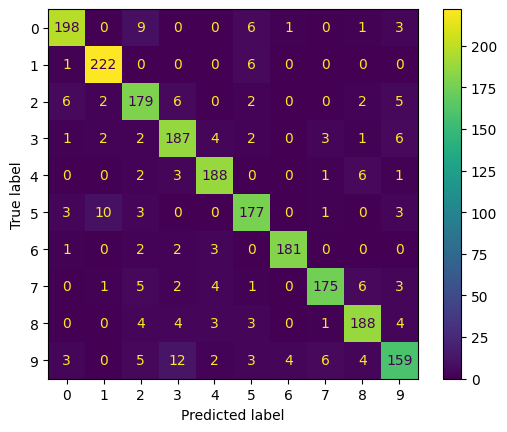

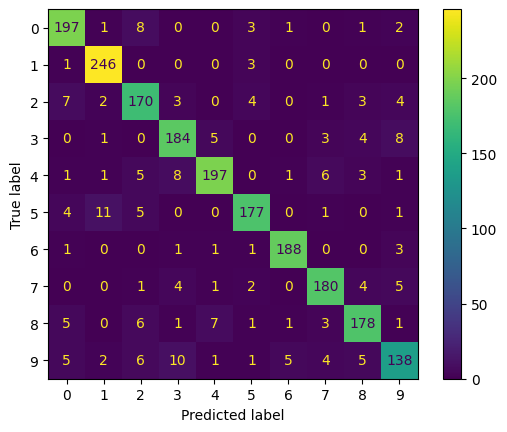

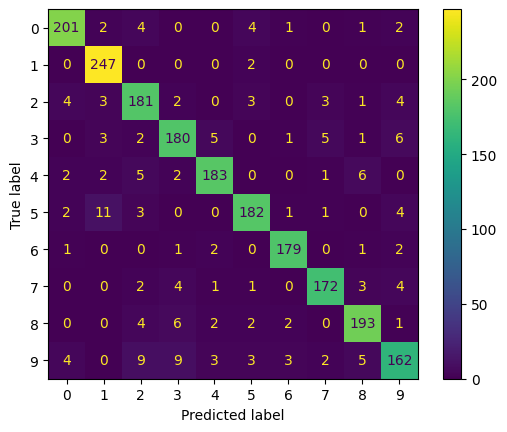

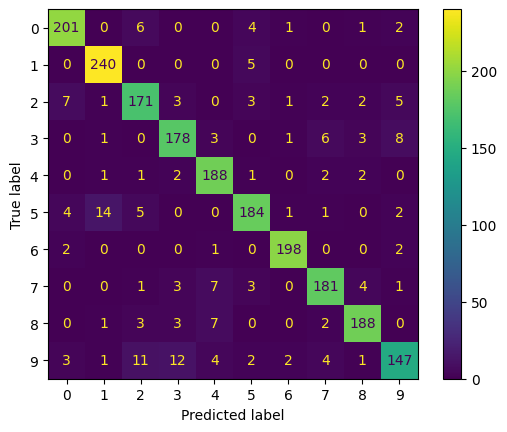

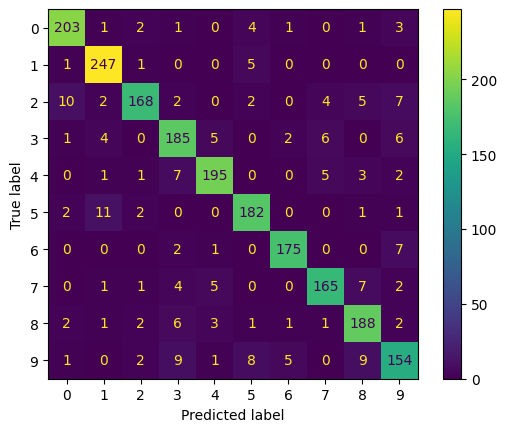

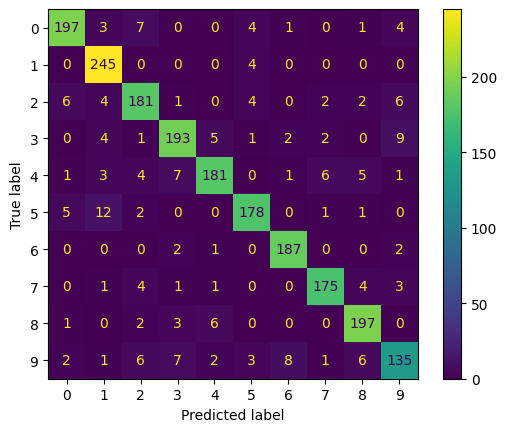

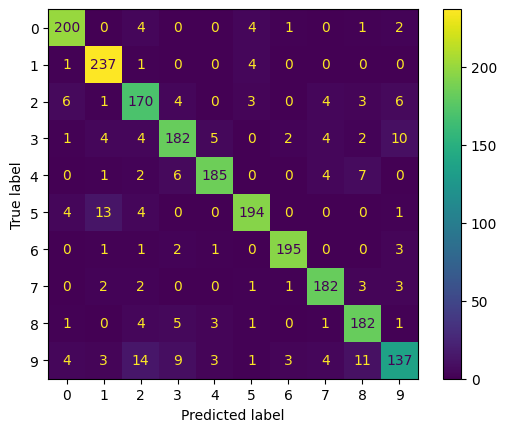

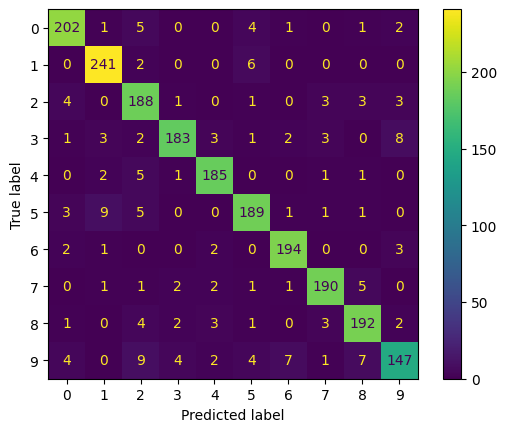

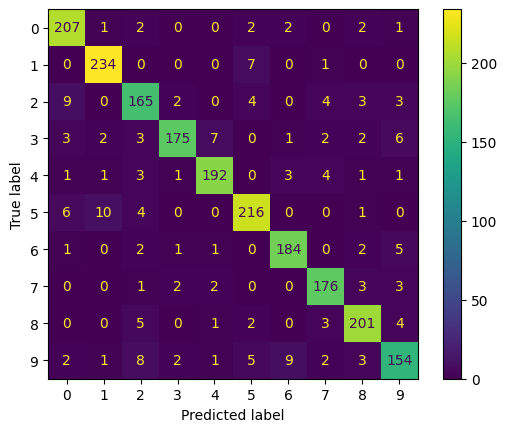

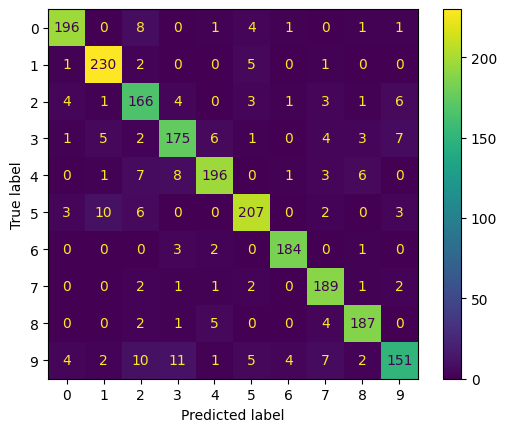

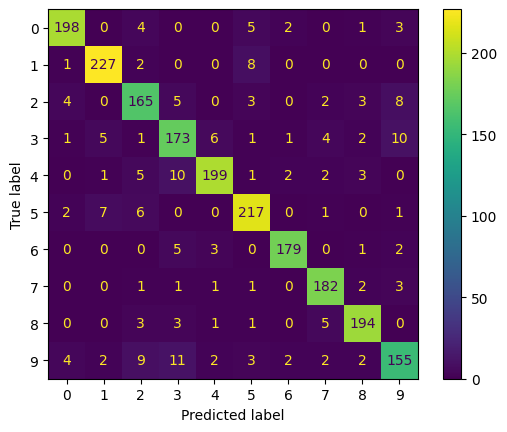

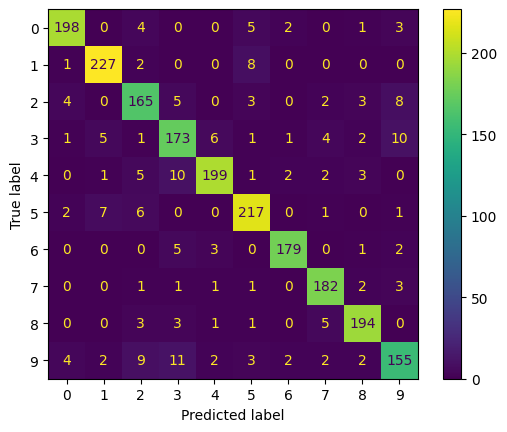

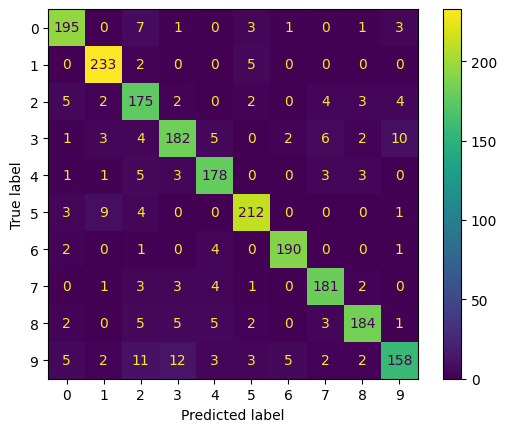

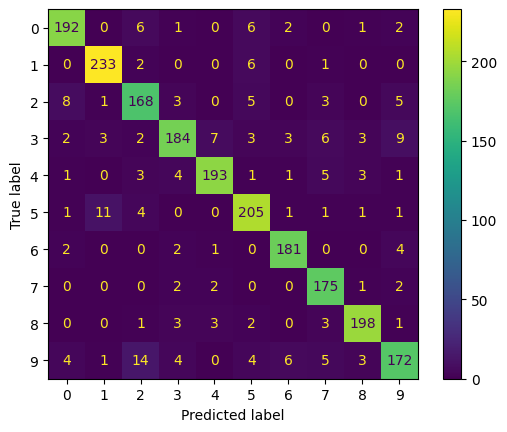

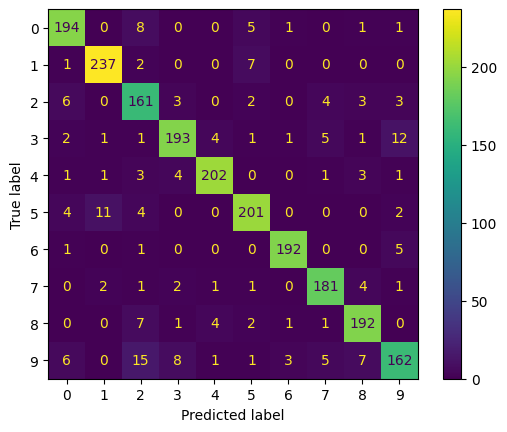

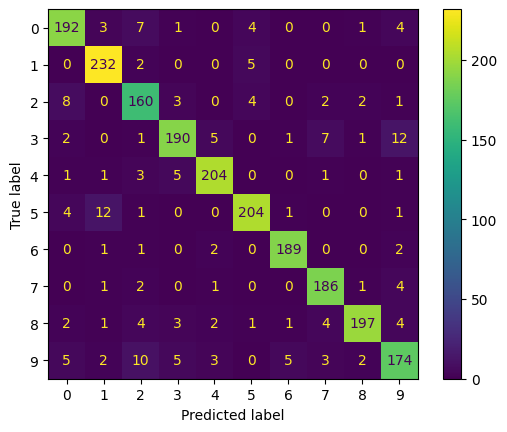

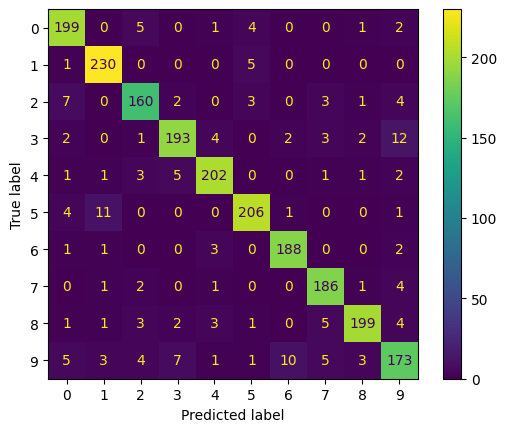

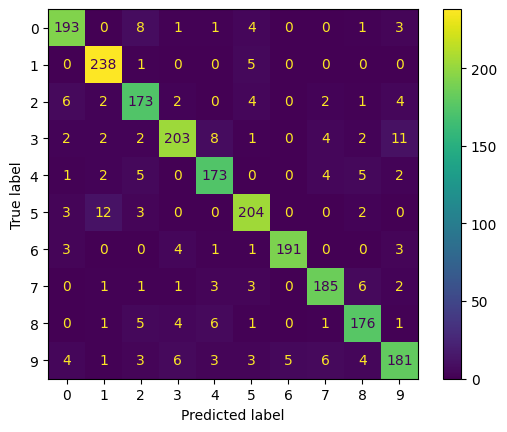

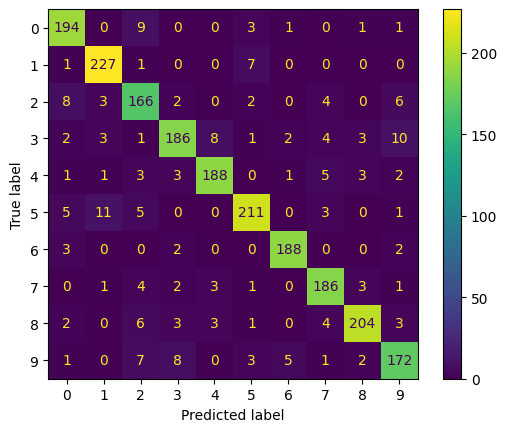

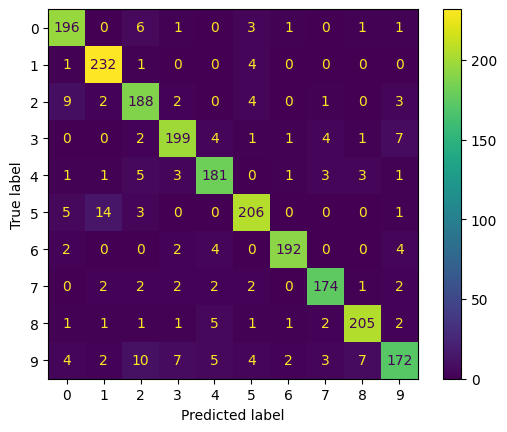

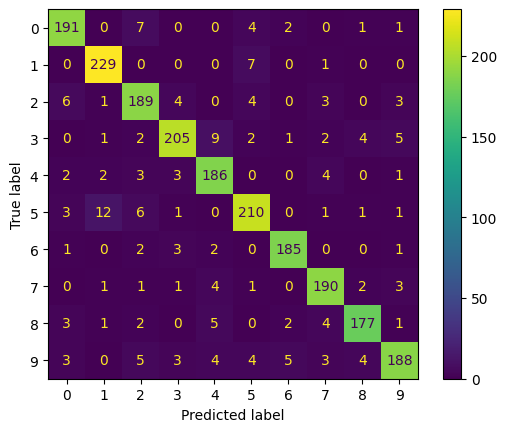

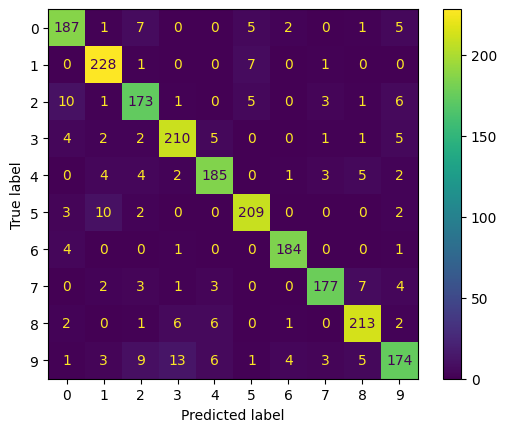

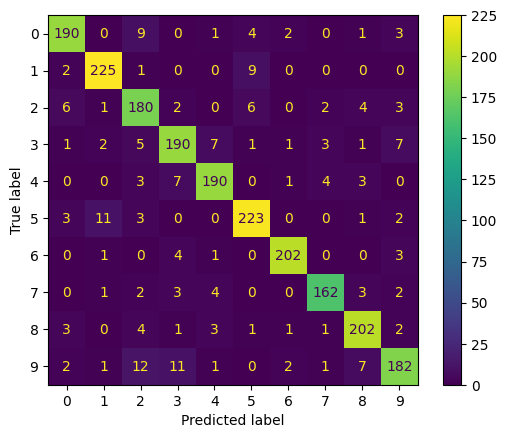

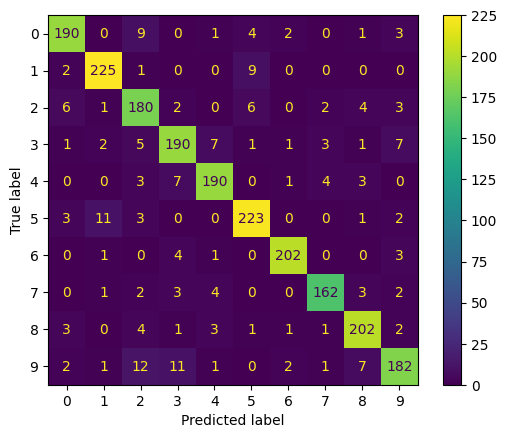

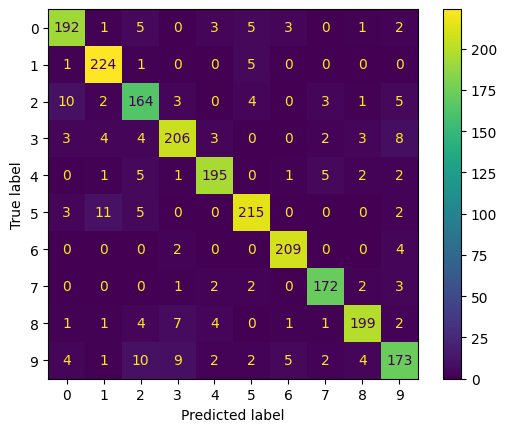

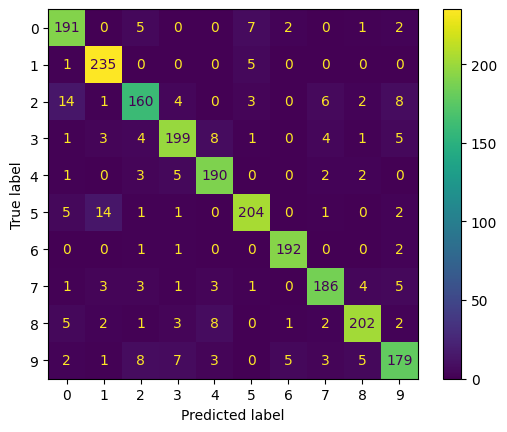

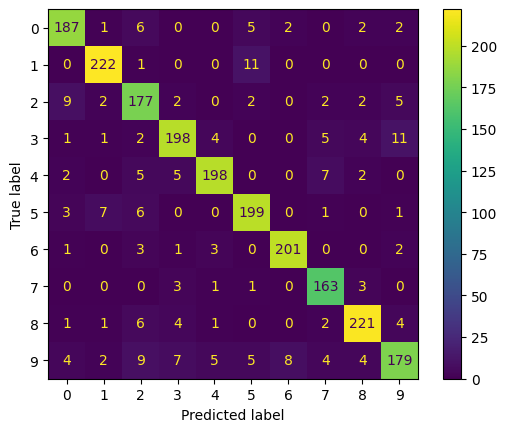

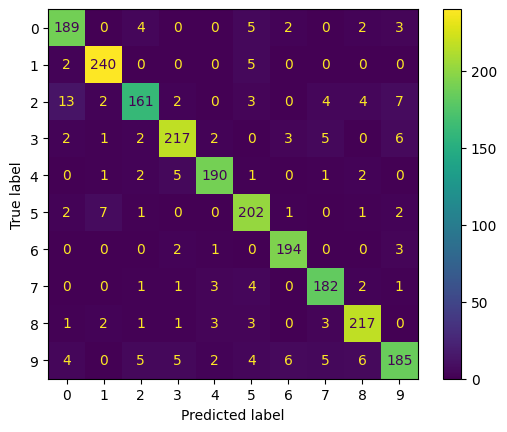

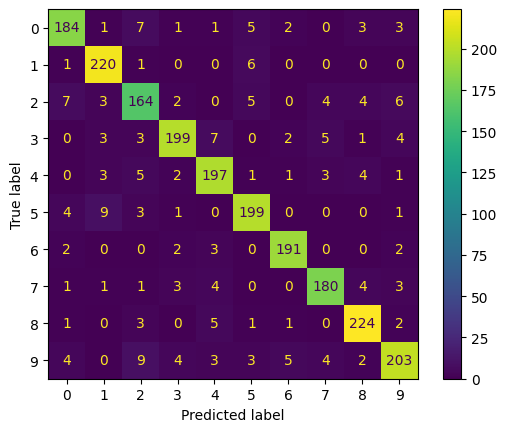

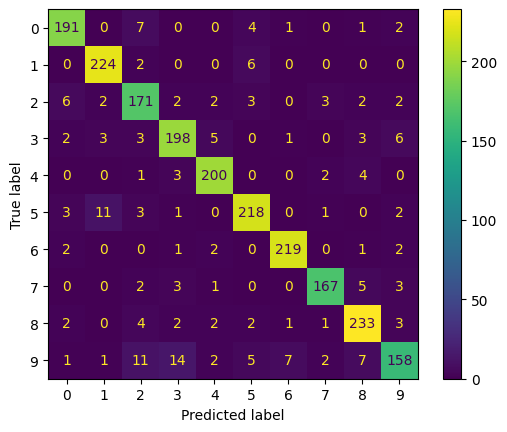

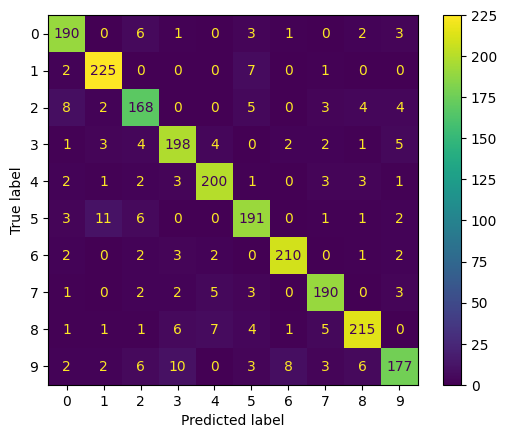

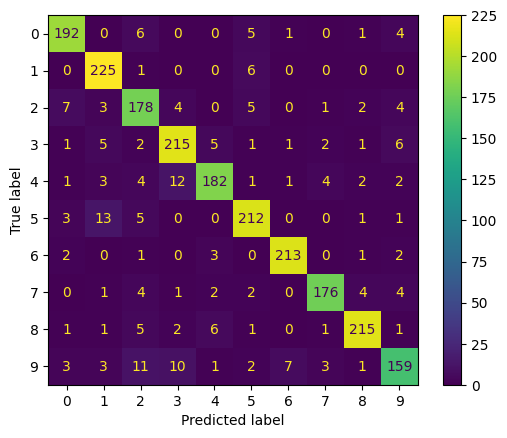

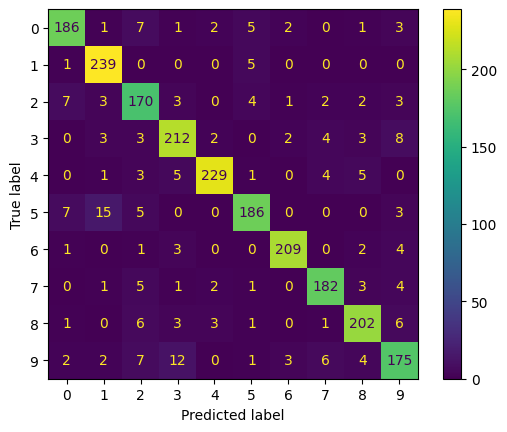

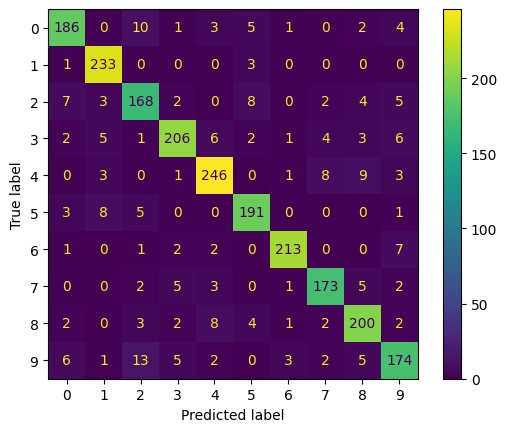

In [10]:
# 1. Data
seuil = 0.1 # ! Boucler en changeant le seuil
base_df = pd.read_csv('./resources/original_dataset.csv')
for genre in os.listdir('./extracted_drive_dataset/'):
    for extracted_features in os.listdir(f'./extracted_drive_dataset/{genre}/'):
            kept_df = pd.DataFrame(columns=column_names)
            dataframe = pd.read_csv(f"./extracted_drive_dataset/{genre}/{extracted_features}")
            # 2. Model
            my_model = MusicClassifier(input_features=55, output_features=10)
            my_model.load_state_dict(
                torch.load(
                    f="./resources/actual_model_fast.pth", map_location=torch.device("cpu")
                )
            )
            dataframe.drop(columns=['label'], inplace=True)
            
            # 3. Prediction
            result, raw_results = predict(my_model, dataframe, genre_mapping, real_class=genre)

            # 4. Filter new data
            kept_df = filter_data(kept_df, seuil, raw_results, dataframe, real_class=int(genre))
            
            # 4.1 Concat with original dataset
            base_df = pd.concat([base_df, kept_df], axis=0)

            # 5. Training loop and 6. metrics
            pd.options.mode.chained_assignment = None # ! Test
            training_loop(MusicClassifier, df=base_df)